# Continuous Control

---
### 1. Start the Environment

We begin by importing the necessary packages.

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import time
from workspace_utils import active_session 
from ddpg_agent import Agent
%matplotlib inline

cuda:0


## Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Trainning 

#### Hyper parameters

```python
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 1        # update the network after every UPDATE_EVERY timestep
UPDATE_TIMES = 1        # update UPDATE_TIME for every update
EPSILON = 1             # epsilon noise parameter
EPSILON_DECAY = 0       # decay parameter of epsilon
```

For trainning the agent `n_episodes=2000` is set as default with max times steps as `max_t=1000`. A `train` argument is added to the funtion for trainning and evalution perpose. The environment is considered as solved when the agnet achives `30` as avg. reward across all playing agents.

In [9]:
def ddpg(n_episodes=2000, max_t=1000, train=True):
    start_time = time.time()
    scores_deque = deque(maxlen=100)
    scores_mean_agent = []
    scores_mean = []
    max_score = -np.Inf
    
    if not train:
        agent.load_weights('checkpoint_actor.pth','checkpoint_critic.pth')
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[brain_name] 
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        for t in range(max_t):
            
            actions = agent.act(states,add_noise=train)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations  # get the next state
            rewards = env_info.rewards  # get the reward
            dones = env_info.local_done # get the dones
            
            if train:
                agent.step(states, actions, rewards, next_states, dones, t)
                      
            states = next_states
            scores += rewards
            if np.any(dones):
                break       
        score = np.mean(scores)
        scores_deque.append(score)
        scores_mean_agent.append(score)
        scores_mean.append(np.mean(scores_deque))
        
        if i_episode % 10 == 0 :
            duration = (int)(time.time() - start_time)  
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tMin: {:.2f}\tMax: {:.2f}\tepsilon {:.4f}\tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque),score,  np.min(scores), np.max(scores),agent.epsilon,\
                          duration//3600, duration%3600//60, duration%60))
        else:
             print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tMin: {:.2f} \tMax: {:.2f}\tepsilon {:.2f}'\
              .format(i_episode, np.mean(scores_deque), score, np.min(scores), np.max(scores),agent.epsilon), end="")
                
        if np.mean(scores_deque) >= 30.0 and train :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode , np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break  
    return scores_mean_agent,scores_mean



Initializing the Agnet with env. action size and env state size

In [7]:

env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
action_size = brain.vector_action_space_size           # get the action size
state_size = states.shape[1]                           # get the state size
random_seed = 2
agent = Agent(state_size,action_size,num_agents,random_seed)      # init the agent


lets train the agent

Episode 10	Average Score: 0.65	Score: 1.13	Min: 0.29	Max: 2.78	epsilon 1.0000	Time: 00:02:18
Episode 20	Average Score: 1.24	Score: 2.54	Min: 0.99	Max: 5.10	epsilon 1.0000	Time: 00:04:39
Episode 30	Average Score: 1.89	Score: 4.17	Min: 0.78	Max: 6.25	epsilon 1.0000	Time: 00:07:02
Episode 40	Average Score: 2.79	Score: 6.59	Min: 1.34	Max: 12.60	epsilon 1.0000	Time: 00:09:23
Episode 50	Average Score: 5.89	Score: 26.86	Min: 20.59	Max: 35.77	epsilon 1.0000	Time: 00:11:44
Episode 60	Average Score: 10.32	Score: 35.96	Min: 31.00	Max: 38.22	epsilon 1.0000	Time: 00:14:04
Episode 70	Average Score: 14.16	Score: 37.00	Min: 34.44	Max: 39.28	epsilon 1.0000	Time: 00:16:25
Episode 80	Average Score: 16.95	Score: 35.76	Min: 27.66	Max: 39.12	epsilon 1.0000	Time: 00:18:45
Episode 90	Average Score: 19.06	Score: 36.05	Min: 32.46	Max: 39.53	epsilon 1.0000	Time: 00:21:06
Episode 100	Average Score: 20.74	Score: 35.31	Min: 30.64	Max: 38.32	epsilon 1.0000	Time: 00:23:25
Episode 110	Average Score: 24.27	Score: 36.90

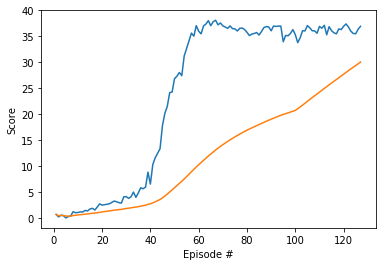

In [8]:

with active_session():
    scores,scores_mean= ddpg()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores,label="score")
    plt.plot(np.arange(1, len(scores_mean)+1), scores_mean,label="avg score")
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    plt.savefig('train.png')

### 4. Evaluation
Lets run the agnet with trainned weights

Episode 5	Average Score: 39.43	Score: 39.44	Min: 38.92 	Max: 39.66	epsilon 1.00

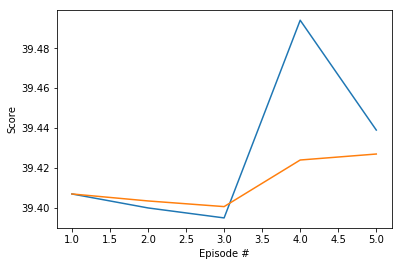

In [10]:

scores,scores_mean= ddpg(n_episodes=5, max_t=1000, train=False)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,label="score")
plt.plot(np.arange(1, len(scores_mean)+1), scores_mean,label="avg score")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig('eval.png')

When finished, you can close the environment.

In [11]:
env.close()